In [1]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

import matplotlib 
if not is_notebook():
    matplotlib.use('Agg')

In [2]:
import os
import math
import json
import random as rnd
from typing import Optional, Callable
from tqdm import tqdm
from collections import defaultdict
from functools import partial
from datetime import datetime
import itertools
from dataclasses import dataclass
from pathlib import Path
from enum import Enum

from omegaconf import OmegaConf
import submitit
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import matplotlib.pyplot as plt
import pandas as  pd
import torchvision.utils as vision_utils
from PIL import Image
import torchvision
from torchvision import transforms
from matplotlib.ticker import NullFormatter

from losses.divdis import DivDisLoss 
from losses.divdis import DivDisLoss
from losses.ace import ACELoss
from losses.dbat import DBatLoss
from losses.loss_types import LossType

from models.backbone import MultiHeadBackbone
from models.multi_model import MultiNetModel
from models.lenet import LeNet
from utils.utils import conf_to_args


# Experiment Utils

In [3]:
@dataclass
class Experiment:
    seed: int
    loss_type: LossType
    model: str
    mix_rate: float
    mix_rate_lower_bound: float
    lr: float
    aux_weight: float
    epochs: int

In [4]:
def get_executor(out_dir: Path):
    executor = submitit.AutoExecutor(folder=out_dir)
    executor.update_parameters(
        timeout_min=60 * 48,
        mem_gb=16,
        gres="gpu:1",
        cpus_per_task=4,
        nodes=1,
        slurm_qos="high",
        slurm_array_parallelism=8
    )
    return executor
def get_executor_local(out_dir: Path):
    executor = submitit.LocalExecutor(folder=out_dir)
    executor.update_parameters(
        timeout_min=60 * 48,
    )
    return executor

script_name = "cifar_mnist.py"
def run_experiments(executor, experiments: list[Experiment], script_name: str):

    with executor.batch():
        jobs = []
        for exp in experiments:
            function = submitit.helpers.CommandFunction(
                ["python", script_name] + conf_to_args(exp.__dict__)
            )
            jobs.append(executor.submit(function))
    return jobs

# Run Hyperparameter Sweeps

In [ ]:
# for now we'll just sweep lr on source accuracy, use values for all losses 
seeds = [100, 101, 102]
num_epochs = 10 
resnet_50_lr_range = [1e-4, 1e-3, 1e-2]
vit_b_16_lr_range = [2e-5, 3e-5, 4e-5, 5e-5]
model_and_lr_range = [("Resnet50", lr) for lr in resnet_50_lr_range] + [("ClipVit", lr) for lr in vit_b_16_lr_range]
losses = [LossType.PROB, LossType.DIVDIS, LossType.EXP]


hyperparameter_sweep_exps = []
for resnet_50_lr in resnet_50_lr_range:
        hyperparameter_sweep_exps.append(Experiment(seed, loss, model, mix_rate, mix_rate_lower_bound, epochs))

# is there a reasonable way to pick aux weights without knowing ground truth 
# we can use loss without out weights, but would be very strange if that worked (we should expect incrased loss weight to shift allocation away from cross etnropy on source)
num_epochs = 5
resnet_50_lr_range = [1e-5, 1e-4, 1e-3]
vit_b_16_lr_range = [1e-6, 1e-5, 1e-4]
losses = [LossType.PROB, LossType.DIVDIS, LossType.EXP]
loss_to_lr_lower_bound_map = {
    LossType.PROB: [0.1], 
    LossType.DIVDIS: [0.1], 
    LossType.EXP: []
}
mix_rates = [0.5, ]


hyperparameter_sweeps = list(itertools.product(resnet_50_lr_range, vit_b_16_lr_range, aux_weights))




# Run Experiments

In [7]:
seeds = [0, 1, 2]
losses = [LossType.PROB, LossType.DIVDIS, LossType.EXP]
models = ["Resnet50"]
aux_weights = [1, 10]
# mix rates and lower bounds (same mix rate and lower bound, fixed lower bound and varying mix rate)
mix_rates = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
mix_rate_lower_bounds = [0.1] # [0.1, 0.5, 1.0]
same_mix_rate_and_lower_bounds = [
    (mix_rate, mix_rate) for mix_rate in mix_rates
]
fixed_lower_bounds_and_mix_rates = list(itertools.product(
    mix_rates, mix_rate_lower_bounds
))
mix_rates_and_lower_bounds = list(set(same_mix_rate_and_lower_bounds + fixed_lower_bounds_and_mix_rates))

mix_rate_to_epoch: dict[float, int] = {
    0.1: 100,
    0.25: 100,
    0.5: 50,
    0.75: 50,
    0.9: 50,
    1.0: 50
}
# mix_rate_to_epoch = defaultdict(lambda: 20)
experiments: list[Experiment] = []

for seed in seeds:
    for loss in losses:
        for model in models:
            for mix_rate, mix_rate_lower_bound in mix_rates_and_lower_bounds:
                epochs = mix_rate_to_epoch[mix_rate]
                experiments.append(Experiment(seed, loss, model, mix_rate, mix_rate_lower_bound, epochs))
print(len(experiments))

99


In [17]:
out_dir = Path("output_logs/cifar_mnist_sweep")
out_dir.mkdir(exist_ok=True, parents=True)

executor = get_executor(out_dir)
jobs = run_experiments(executor, experiments, script_name)


/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [18]:
print(jobs[0].stderr())
print(jobs[0].stdout())



submitit INFO (2024-10-22 18:17:46,649) - Starting with JobEnvironment(job_id=493274_0, hostname=ddpg.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-10-22 18:17:46,650) - Loading pickle: /nas/ucb/oliveradk/diverse-gen/output_logs/cifar_mnist_sweep/493274_0_submitted.pkl
The following command is sent: "python cifar_mnist.py seed=0 loss_type=PROB model=Resnet50 mix_rate=0.5 mix_rate_lower_bound=0.5 epochs=50"



# Process Results

In [8]:
# create directory from config
result_dir = Path("output/cifar_mnist")
def exp_to_dir_name(exp: Experiment):        
    dir_name = f"{exp.loss_type.name}_{exp.model}_{exp.mix_rate}_{exp.mix_rate_lower_bound}_{exp.epochs}_{exp.seed}"
    return dir_name

In [9]:
def get_exp_metrics(exp: Experiment):
    exp_dir = result_dir / exp_to_dir_name(exp)
    # find most recent directory in exp_dir
    most_recent_dir = sorted(exp_dir.iterdir(), key=lambda x: x.stat().st_ctime)[-1]
    # load results.json
    with open(most_recent_dir / "metrics.json", "r") as f:
        exp_metrics = json.load(f)
    return exp_metrics

def get_max_acc_at_min_val_loss(exp_metrics: dict):
    min_val_loss_idx = np.argmin(exp_metrics["target_val_loss"])
    max_acc = max(exp_metrics['epoch_acc_0'][min_val_loss_idx], exp_metrics['epoch_acc_1'][min_val_loss_idx])
    return max_acc


In [10]:
# end goal: mean and std of cifar test acc selected according to total val loss for each method across mix rates 

# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
results = defaultdict(lambda: defaultdict(list))
for exp in experiments:
    if exp.mix_rate != exp.mix_rate_lower_bound:
        continue
    exp_metrics = get_exp_metrics(exp)
    max_acc = get_max_acc_at_min_val_loss(exp_metrics)
    results[exp.loss_type][exp.mix_rate].append(max_acc)
results = {k: dict(v) for k, v in results.items()}
    



In [11]:
# results fixed lower bound 
results_fixed_lower_bound = {lower_bound: defaultdict(lambda: defaultdict(list)) for lower_bound in mix_rate_lower_bounds}
for lower_bound in mix_rate_lower_bounds:   
    for exp in experiments:
        if exp.mix_rate_lower_bound != lower_bound:
            continue
        exp_metrics = get_exp_metrics(exp)  
        max_acc = get_max_acc_at_min_val_loss(exp_metrics)
        results_fixed_lower_bound[lower_bound][exp.loss_type][exp.mix_rate].append(max_acc)
results_fixed_lower_bound = {k: dict(v) for k, v in results_fixed_lower_bound.items()}


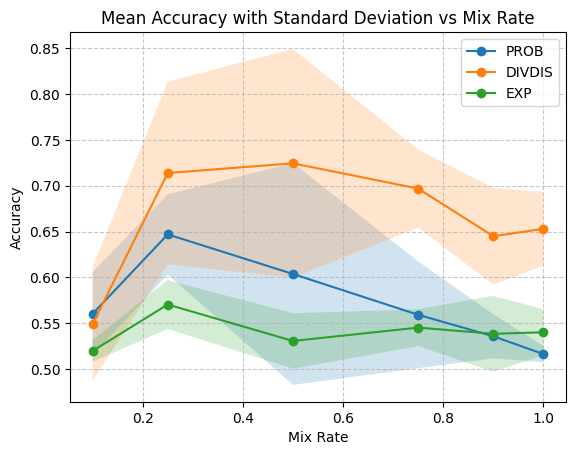

In [14]:
# plot mean accuracy with dotted standard deviation for each method type at each mix rate
for loss_type, loss_results in results.items():
    mix_rates = sorted(loss_results.keys())
    means = [np.mean(loss_results[mix_rate]) for mix_rate in mix_rates]
    stds = [np.std(loss_results[mix_rate]) for mix_rate in mix_rates]
    
    plt.plot(mix_rates, means, label=loss_type.name, marker='o')
    plt.fill_between(mix_rates, 
                     [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     alpha=0.2)

plt.xlabel('Mix Rate')
plt.ylabel('Accuracy')
plt.title('Mean Accuracy with Standard Deviation vs Mix Rate')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

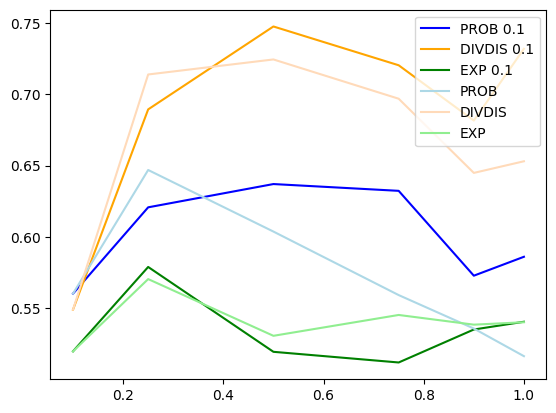

In [15]:
results_lower_bound_0_1 = results_fixed_lower_bound[0.1]
# plot mean accuracy for each method type at each mix rate
color_map = {LossType.PROB: "blue", LossType.DIVDIS: "orange", LossType.EXP: "green"}
off_colors = {LossType.PROB: "lightblue", LossType.DIVDIS: "peachpuff", LossType.EXP: "lightgreen"}
for loss_type, loss_results in results_lower_bound_0_1.items():
    plt.plot(sorted(loss_results.keys()), [np.mean(loss_results[mix_rate]) for mix_rate in sorted(loss_results.keys())], label=f"{loss_type.name} 0.1", color=color_map[loss_type])
for loss_type, loss_results in results.items():
    plt.plot(sorted(loss_results.keys()), [np.mean(loss_results[mix_rate]) for mix_rate in sorted(loss_results.keys())], label=loss_type.name, color=off_colors[loss_type])
plt.legend()
plt.show()

In [16]:
[exp.epochs for exp in experiments]

[50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 100,
 50,
 100,
 100,
 50,
 50]